In [23]:
# Import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# 라벨링
def encode_labels(*args, to_numpy=False):
    le = preprocessing.LabelEncoder()
    encoded_lists = [le.fit_transform(arg) for arg in args]
    
    if to_numpy:
        return [np.array(encoded) for encoded in encoded_lists]
    
    return encoded_lists
# 결측값 처리
class MissingValueHandler:
    def __init__(self, dataframe):
        self.df = dataframe

    def fill_missing(self, column_data, method):
        if method == 'mean':
            return column_data.fillna(column_data.mean())
        elif method == 'median':
            return column_data.fillna(column_data.median())
        elif method == 'mode':
            return column_data.fillna(column_data.mode()[0])
        elif method == 'zero':
            return column_data.fillna(0)
        else:
            raise ValueError("지원하지 않는 방법입니다. 'mean', 'median', 'mode', 또는 'zero' 중에서 선택하세요.")

    def drop(self):
        return self.df.dropna()

    def drop_loc(self):
        return self.df.dropna(axis=1)

    def get_dataframe(self):
        return self.df

    def summarize(self, preprocessing=False):
        #데이터프레임의 합계와 결측값 수를 출력하는 메서드
        if preprocessing:
            print("--- After Fill Missing ---")
            print("\nNumber of missing values in each column:")
        else:
            print("--- Before Fill Missing ---")
            print("Sum of each numeric column:")
        
        if not preprocessing:
            print(self.df.dtypes)
        
        print("\nNumber of missing values in each column:")
        print(self.df.isnull().sum())
        print("\n" + "-" * 30)

# 라벨링
class CategoricalEncoder:
    def __init__(self, dataframe):
        from sklearn import preprocessing
        self.df = dataframe

    def encode_labels(self):
        categorical_cols = self.df.select_dtypes(include=['object']).columns # 범주형 열 선택
        encoded_arrays = encode_labels(*[self.df[col] for col in categorical_cols], to_numpy=True) # 선택된 범주형 열을 인코딩하고 DataFrame으로 변환
        encoded_df = pd.DataFrame(encoded_arrays).T  # 인코딩된 결과를 DataFrame으로 결합, 전치하여 행과 열을 맞춤
        encoded_df.columns = categorical_cols # 인코딩된 열 이름 설정
        self.df.loc[:, categorical_cols] = encoded_df # .loc를 사용하여 원래 DataFrame에 인코딩된 열 대체

        return self.df
        
# X. y 분리
def split_features_and_target(encoded_df, target_column):
    
    X = encoded_df.drop(columns=[target_column])  # 타겟 열 제외
    y_labels = encoded_df[target_column]  # 타겟 열 선택
    return X, y_labels


# 1. 데이터 전처리
#X = dataset.iloc[:, :-1].values  # 특성
#labels = dataset.iloc[:, -1].values  # 레이블

# 스케일링 StandardScaler
def scale_data_SS(X_train, X_test):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터 스케일링
    X_test_scaled = scaler.transform(X_test)        # 테스트 데이터 스케일링
    return X_train_scaled, X_test_scaled

# 스케일링 StandardScaler
def scale_data_MMS(X_train, X_test):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터 스케일링
    X_test_scaled = scaler.transform(X_test)        # 테스트 데이터 스케일링
    return X_train_scaled, X_test_scaled





"""모델 선택"""
class MI:  # ModelInitializer
    def __init__(self, model_type='naive_bayes', **kwargs):
        self.model = self.initialize_model(model_type, **kwargs)
        if X_train is not None and y_train is not None:
            self.fit_model(X_train, y_train)

    def initialize_model(self, model_type, **kwargs):
        """모델 초기화 함수."""
        if model_type == 'GaussianNB':
            from sklearn.naive_bayes import GaussianNB
            model = GaussianNB(**kwargs)  # 지도 분류 / 큰 데이터셋에 적합, 노이즈 데이터 셋 가능
            print("Initialized GaussianNB model (suitable for larger datasets with noise).")
        elif model_type == 'SVM':
            from sklearn.svm import SVC
            model = SVC(**kwargs)  # 지도 분류 / 적은 데이터 적합, 노이즈가 많은 데이터 적은 셋 적합.
        elif model_type == 'DecisionTreeClassifier':
            from sklearn.tree import DecisionTreeClassifier
            model = DecisionTreeClassifier(**kwargs)  # 지도 분류 / 의사 결정 나무
        elif model_type == 'RandomForestRegressor':
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(**kwargs)  # 지도 분류 / 랜덤포레스트
        elif model_type == 'PCA':
            from sklearn.decomposition import PCA
            model = PCA(**kwargs)  # PCA 부분작동
        elif model_type == 'KNeighborsClassifier':
            from sklearn.neighbors import KNeighborsClassifier
            model = KNeighborsClassifier(**kwargs)  # KNN
        else:
            raise ValueError("Invalid model type. Choose 'naive_bayes' or 'SVM'.")
        
        return model
    def fit_model(self, X_train_scaled, y_train_scaled):
        """모델을 학습합니다."""
        self.model.fit(X_train_scaled, y_train_scaled)
        print("Model has been fitted.")
        
    def get_model(self):
        """초기화된 모델을 반환합니다."""
        return self.model


# naive_bayes_model = ML(model_type='naive_bayes').get_model()
# svm_model = ML(model_type='svm', kernel='linear').get_model()




def plot_decision_function(X_train, y_train, X_test, y_test, model):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # NumPy 배열에서의 인덱싱
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='x')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary")
    plt.show()


In [24]:
# 데이터셋 로드
df = sns.load_dataset('titanic')
df_filter = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

# 결측값 확인
MVS = MissingValueHandler(df_filter)
MVS.summarize(preprocessing=False)  # Before 상태

--- Before Fill Missing ---
Sum of each numeric column:
survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

Number of missing values in each column:
survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

------------------------------


In [25]:
# 결측값 처리
df_filter.loc[:, 'age'] = MVS.fill_missing(df_filter['age'], method='mean') 
df_filter.loc[:, 'embarked'] = MVS.fill_missing(df_filter['embarked'], method='mode')
#df_filter.loc[:, '---'] = MVS.fill_missing(df_filter['---'], method='mode')
#df_filter.loc[:, '---'] = MVS.fill_missing(df_filter['---'], method='mode')
MVS.summarize(preprocessing=True) # After 상태

--- After Fill Missing ---

Number of missing values in each column:

Number of missing values in each column:
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

------------------------------


In [26]:
#라벨링
encoder = CategoricalEncoder(df_filter)
df_encoded = encoder.encode_labels()
print(df_encoded)


# 스케일화
#X_train_scaled, X_test_scaled = scale_data_SS(X_train, X_test)
#X_train_scaled, X_test_scaled = scale_data_MMS(X_train, X_test)


# 스케일화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded) # 스케일화
df_encoded_scaled = pd.DataFrame(df_encoded_scaled) # 데이터 프렘임화
# X의 컬럼 이름을 리스트로 가져오기
column_names = df_encoded.columns.tolist()
df_encoded_scaled.columns = column_names
df_encoded_scaled


     survived  pclass sex        age  sibsp  parch     fare embarked
0           0       3   1  22.000000      1      0   7.2500        2
1           1       1   0  38.000000      1      0  71.2833        0
2           1       3   0  26.000000      0      0   7.9250        2
3           1       1   0  35.000000      1      0  53.1000        2
4           0       3   1  35.000000      0      0   8.0500        2
..        ...     ...  ..        ...    ...    ...      ...      ...
886         0       2   1  27.000000      0      0  13.0000        2
887         1       1   0  19.000000      0      0  30.0000        2
888         0       3   0  29.699118      1      2  23.4500        2
889         1       1   1  26.000000      0      0  30.0000        0
890         0       3   1  32.000000      0      0   7.7500        1

[891 rows x 8 columns]


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,-0.789272,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445,0.585954
1,1.266990,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845,-1.942303
2,1.266990,0.827377,-1.355574,-0.284663,-0.474545,-0.473674,-0.488854,0.585954
3,1.266990,-1.566107,-1.355574,0.407926,0.432793,-0.473674,0.420730,0.585954
4,-0.789272,0.827377,0.737695,0.407926,-0.474545,-0.473674,-0.486337,0.585954
...,...,...,...,...,...,...,...,...
886,-0.789272,-0.369365,0.737695,-0.207709,-0.474545,-0.473674,-0.386671,0.585954
887,1.266990,-1.566107,-1.355574,-0.823344,-0.474545,-0.473674,-0.044381,0.585954
888,-0.789272,0.827377,-1.355574,0.000000,0.432793,2.008933,-0.176263,0.585954
889,1.266990,-1.566107,0.737695,-0.284663,-0.474545,-0.473674,-0.044381,-1.942303


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X_cross, y_label_scross = split_features_and_target(df_encoded_scaled, 'survived')  # 특징과 타겟 분리

logreg = LogisticRegression()

y_labels_cross = (y_labels_cross >= 0.5).astype(int)
scores = cross_val_score(logreg, X_cross, y_labels_cross, cv=5)
print("교차 검증 점수: ", scores)

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 891, dtype: int64
교차 검증 점수:  [0.77653631 0.78651685 0.78089888 0.76404494 0.81460674]


In [5]:

# 학습 분리
X, y_labels = split_features_and_target(df_encoded_scaled, 'survived')  # 특징과 타겟 분리

from sklearn.linear_model import Lasso

# 모델 초기화 및 훈련
regression = Lasso(alpha=0.1)  # alpha는 λ에 해당
regression.fit(X, y_labels)

coefficients = regression.coef_
print(coefficients)

# 0이 아닌 계수를 가진 feature만 선택
important_features = [i for i in range(len(coefficients)) if coefficients[i] != 0]
print("선택된 feature의 인덱스:", important_features)
selected_column_names = [df.columns[i] for i in important_features]
print("선택된 feature의 열 이름:", selected_column_names,"전체 컬럼 이름" ,X.columns.tolist())

X_Lasso = X.iloc[:, important_features]
print("선택된 feature의 데이터:\n", X_Lasso)

[-0.18318994 -0.41918854 -0.         -0.         -0.          0.
 -0.        ]
선택된 feature의 인덱스: [0, 1]
선택된 feature의 열 이름: ['survived', 'pclass'] 전체 컬럼 이름 ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
선택된 feature의 데이터:
        pclass       sex
0    0.827377  0.737695
1   -1.566107 -1.355574
2    0.827377 -1.355574
3   -1.566107 -1.355574
4    0.827377  0.737695
..        ...       ...
886 -0.369365  0.737695
887 -1.566107 -1.355574
888  0.827377 -1.355574
889 -1.566107  0.737695
890  0.827377  0.737695

[891 rows x 2 columns]


In [20]:
# 학습 분리
X_Lasso, y_labels = split_features_and_target(df_encoded, 'survived')  # 특징과 타겟 분리
X_train, X_test, y_train, y_test = train_test_split(X_Lasso, y_labels, test_size=0.3, random_state=109)


# 모델 선택 및 피팅
#model = MI(model_type='GaussianNB').get_model()
#model = MI(model_type='SVM', kernel='linear', C=1, gamma=0.01).get_model()
#model = MI(model_type='DecisionTreeClassifier', random_state=0, max_depth=4).get_model() # 중요도 사용 가능
#model = MI(model_type='RandomForestRegressor', n_estimators=100, random_state=42).get_model() # 중요도 사용 가능
#model = MI(model_type='PCA', n_components=0.95).get_model() #X_model=model.fit_transform(X_train) ??
model = MI(model_type='KNeighborsClassifier', n_neighbors=1).get_model()

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


from sklearn.metrics import accuracy_score, classification_report
print("훈련 세트 정확도: {:.3f}".format(model.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(model.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
#print(f"Classification Report:\n{classification_report(y_test, y_pred)}")



Model has been fitted.
훈련 세트 정확도: 0.982
테스트 세트 정확도: 0.728
[[122  34]
 [ 39  73]]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       156
           1       0.68      0.65      0.67       112

    accuracy                           0.73       268
   macro avg       0.72      0.72      0.72       268
weighted avg       0.73      0.73      0.73       268



/tmp/ipykernel_5248/849642687.py:168: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='x')


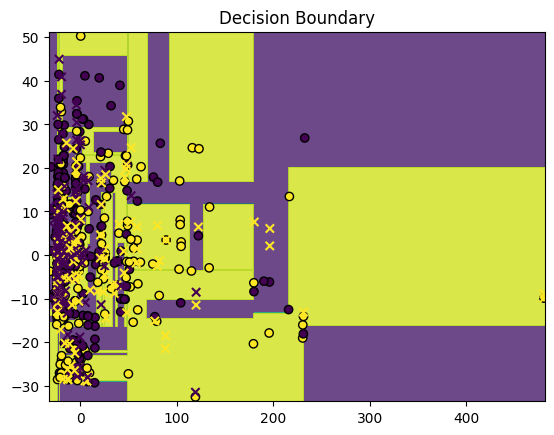

In [90]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# 데이터 분할 (예: 원본 데이터 X와 y가 있다고 가정)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA로 차원 축소
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# 차원 축소된 데이터를 사용하여 모델 훈련
model = DecisionTreeClassifier()
model.fit(X_train_2d, y_train)

# 차원 축소된 데이터를 사용하여 결정 경계 시각화
plot_decision_function(X_train_2d, y_train, X_test_2d, y_test, model)

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# 특성 중요도 추출
feature_importances = model.feature_importances_

# 특성 중요도를 데이터프레임으로 변환
feature_importances_df = pd.DataFrame({
    'Feature': df_X.columns,
    'Importance': feature_importances
})

# 중요도 순으로 정렬
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances in Random Forest')
plt.show()

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [40]:

# 2차원 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_model[:, 0], y=X_model[:, 1], hue=y, palette='viridis', legend=None)
plt.title('PCA of MNIST Dataset (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

NameError: name 'y' is not defined

<Figure size 1000x700 with 0 Axes>

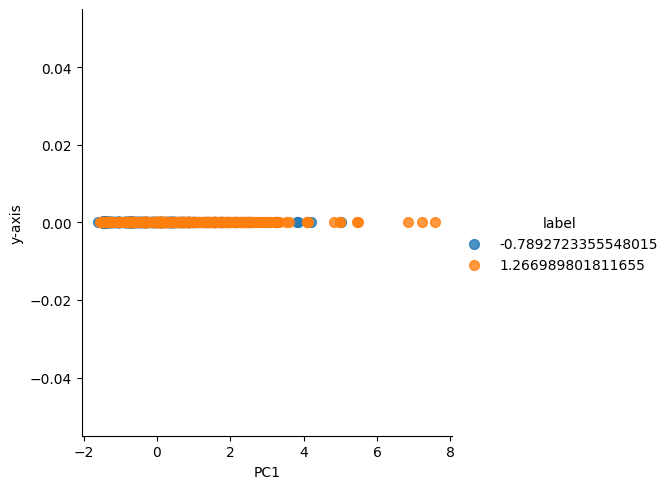

In [7]:
# 학습 분리
X, y_labels = split_features_and_target(df_encoded_scaled, 'survived')  # 특징과 타겟 분리

from sklearn import decomposition
pca = decomposition.PCA(n_components=1)
sklearn_pca_x = pca.fit_transform(X)

sklearn_result = pd.DataFrame(sklearn_pca_x, columns=['PC1'])
sklearn_result['y-axis'] = 0.0
sklearn_result['label'] = y_labels

sns.lmplot(x='PC1', y='y-axis', data=sklearn_result, fit_reg=False, 
           scatter_kws={"s": 50}, hue='label')

In [ ]:
임계값 조절
from sklearn.metrics import confusion_matrix

# 예측 확률을 얻습니다.
y_prob = model.predict_proba(X_test)[:, 1]  # Positive 클래스의 확률을 선택합니다.

# 원하는 임계값을 설정합니다.
threshold = 0.2  # 예: 0.5로 설정

# 임계값에 따라 예측을 만듭니다.
y_pred_custom = (y_prob >= threshold).astype(int)
print(y_pred_custom)


print(confusion_matrix(y_test, y_pred_custom))
print("예측 확률 통계량:", np.min(y_prob), np.max(y_prob), np.mean(y_pred_custom))
